In [18]:
import os
import sys
import numpy as np
import itertools
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from tqdm import tqdm

### Definition of the probability to have an observation

\begin{equation}
p(x) = \frac{1}{1 + e^{-(b_0 + b_1 x)}}
\end{equation}
with $b_0$, $b_1$ the free parameters

In [19]:
def p_obs(x, param):
    
    b0, b1 = param
    logit = b0 + x * b1
    _p_obs = 1. / (1 + np.exp(-logit))
    return _p_obs

### Define parameters of the experiments

In [ ]:
# Seed the random number generator
np.random.seed(123)

# Define design space
n_design = 100
bounds_design = -10, 10
design = np.linspace(*bounds_design, n_design)

# Define parameter space
bounds_param = (-10, 10), (-10, 10)
grid = np.array(list(itertools.product(
    *(np.linspace(*b, 100) for b in bounds_param))))
n_param_set, n_param = grid.shape

# Set the number of trial
n_trial = 500

# Here are the true parameters that are assumed to be unknown
param = [2.0, 1.0]  

### Show the value of $p$ against the design space
using the true parameters

In [ ]:
fig, ax = plt.subplots()
x = design
y = p_obs(x=x, param=param)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_ylim(-0.01, 1.01)
plt.show()

### Run the experiment

In [ ]:
# Results container
engine = ('random', 'ado')
means = {e: np.zeros((n_param, n_trial)) for e in engine}
stds = {e: np.zeros((n_param, n_trial)) for e in engine}

In [ ]:
# Log-lik
p_one = np.array([p_obs(d, param=grid.T)
                  for d in design])  # shape: (n design, n param set)
p_zero = 1 - p_one

p = np.zeros((n_design, n_param_set, 2))
p[:, :, 0] = p_zero
p[:, :, 1] = p_one
log_lik = np.log(p + np.finfo(np.float).eps)

In [ ]:
# Random --------------------------------------------------------

# Define initial (log) prior
lp = np.ones(n_param_set)
lp -= logsumexp(lp)

for t in range(n_trial):
    
    # Pickup the design
    d_idx = np.random.randint(n_design)
    d = design[d_idx]
    
    # Produce a response using the true parameters
    p_r = p_obs(d, param=param)
    resp = p_r > np.random.random()
    
    # Compute the likelihood of the response
    log_lik_r = log_lik[d_idx, :, int(resp)].flatten()
    
    # Update prior
    lp += log_lik_r
    lp -= logsumexp(lp)
    
    # Compute (estimated) expected value for the parameters
    ep = np.dot(np.exp(lp), grid)
    
    # Compute (estimated) standard deviation for the parameters
    delta = grid - ep
    post_cov = np.dot(delta.T, delta * np.exp(lp).reshape(-1, 1))
    sdp = np.sqrt(np.diag(post_cov))
    
    # Backup for future plot
    means['random'][:, t] = ep
    stds['random'][:, t] = sdp

In [ ]:
# Ado -----------------------------------------------

# Define initial (log) prior
lp = np.ones(n_param_set)
lp -= logsumexp(lp)

# Compute the entropy of the observations
ent_obs = -np.multiply(np.exp(log_lik), log_lik).sum(-1)

for t in tqdm(range(n_trial), file=sys.stdout):

    # Compute the posterior
    post = np.exp(lp)

    # Compute the marginal log likelihood
    extended_lp = np.expand_dims(np.expand_dims(lp, 0), -1)
    mll = logsumexp(log_lik + extended_lp, axis=1) # shape (n_design, n_response)

    # Compute the marginal entropy and conditional entropy
    ent_marg = -np.sum(np.exp(mll) * mll, -1)  # shape (n_design,)
    ent_cond = np.sum(post * ent_obs, axis=1)  # shape (n_design,)

    # Calculate the mutual information
    mutual_info = ent_marg - ent_cond  # shape (num_designs,)
    
    # Pickup the design
    d_idx = np.argmax(mutual_info)
    d = design[d_idx]
    
    # Produce a response using the true parameters
    p_r = p_obs(d, param=param)
    resp = p_r > np.random.random()
    
    # Compute the likelihood of the response
    log_lik_r = log_lik[d_idx, :, int(resp)].flatten()
    
    # Update prior
    lp += log_lik_r
    lp -= logsumexp(lp)
    
    # Compute (estimated) expected value for the parameters
    ep = np.dot(np.exp(lp), grid)
    
    # Compute (estimated) standard deviation for the parameters
    delta = grid - ep
    post_cov = np.dot(delta.T, delta * np.exp(lp).reshape(-1, 1))
    sdp = np.sqrt(np.diag(post_cov))
    
    # Backup for future plot
    means['ado'][:, t] = ep
    stds['ado'][:, t] = sdp

In [ ]:
# Figure -----------------------------------------------

fig, axes = plt.subplots(ncols=n_param, figsize=(12, 6))

colors = [f'C{i}' for i, e in enumerate(engine)]

for i, ax in enumerate(axes):

    for j, e in enumerate(engine):

        _means = means[e][i, :]
        _stds = stds[e][i, :]

        true_p = param[i]
        ax.axhline(true_p, linestyle='--', color='black', alpha=.2)

        ax.plot(_means, color=colors[j], label=e)
        ax.fill_between(range(n_trial), _means - _stds,
                        _means + _stds, alpha=.2, color=colors[j])

        ax.set_title(f'b{i}')
        ax.set_xlabel("trial")
        ax.set_ylabel(f"value")

plt.legend()
plt.tight_layout()
plt.show()

# Figure -----------------------------------------------

fig, axes = plt.subplots(ncols=n_param, figsize=(12, 6))

colors = [f'C{i}' for i, e in enumerate(engine)]

for i, ax in enumerate(axes):

    for j, e in enumerate(engine):

        _means = means[e][i, :]
        _stds = stds[e][i, :]

        true_p = param[i]
        ax.axhline(true_p, linestyle='--', color='black', alpha=.2)

        ax.plot(_means, color=colors[j], label=e)
        ax.fill_between(range(n_trial), _means - _stds,
                        _means + _stds, alpha=.2, color=colors[j])

        ax.set_title(f'b{i}')
        ax.set_xlabel("trial")
        ax.set_ylabel(f"value")

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Seed the random number generator
np.random.seed(123)

# Define design space
n_design = 100
bounds_design = -10, 10
design = np.linspace(*bounds_design, n_design)

# Define parameter space
bounds_param = (-10, 10), (-10, 10)
grid = np.array(list(itertools.product(
    *(np.linspace(*b, 100) for b in bounds_param))))
n_param_set, n_param = grid.shape

# Set the number of trial
n_trial = 500

# Here are the true parameters that are assumed to be unknown
param = [2.0, 1.0]  

### Show the value of $p$ against the design space
using the true parameters

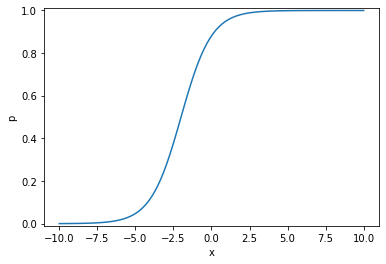

In [21]:
fig, ax = plt.subplots()
x = design
y = p_obs(x=x, param=param)
ax.plot(x, y)
ax.set_xlabel("x")
ax.set_ylabel("p")
ax.set_ylim(-0.01, 1.01)
plt.show()

### Run the experiment

In [22]:
# Results container
engine = ('random', 'ado')
means = {e: np.zeros((n_param, n_trial)) for e in engine}
stds = {e: np.zeros((n_param, n_trial)) for e in engine}

In [23]:
# Log-lik
p_one = np.array([p_obs(d, param=grid.T)
                  for d in design])  # shape: (n design, n param set)
p_zero = 1 - p_one

p = np.zeros((n_design, n_param_set, 2))
p[:, :, 0] = p_zero
p[:, :, 1] = p_one
log_lik = np.log(p + np.finfo(np.float).eps)

In [24]:
# Random --------------------------------------------------------

# Define initial (log) prior
lp = np.ones(n_param_set)
lp -= logsumexp(lp)

for t in range(n_trial):
    
    # Pickup the design
    d_idx = np.random.randint(n_design)
    d = design[d_idx]
    
    # Produce a response using the true parameters
    p_r = p_obs(d, param=param)
    resp = p_r > np.random.random()
    
    # Compute the likelihood of the response
    log_lik_r = log_lik[d_idx, :, int(resp)].flatten()
    
    # Update prior
    lp += log_lik_r
    lp -= logsumexp(lp)
    
    # Compute (estimated) expected value for the parameters
    ep = np.dot(np.exp(lp), grid)
    
    # Compute (estimated) standard deviation for the parameters
    delta = grid - ep
    post_cov = np.dot(delta.T, delta * np.exp(lp).reshape(-1, 1))
    sdp = np.sqrt(np.diag(post_cov))
    
    # Backup for future plot
    means['random'][:, t] = ep
    stds['random'][:, t] = sdp

In [25]:
# Ado -----------------------------------------------

# Define initial (log) prior
lp = np.ones(n_param_set)
lp -= logsumexp(lp)

# Compute the entropy of the observations
ent_obs = -np.multiply(np.exp(log_lik), log_lik).sum(-1)

for t in tqdm(range(n_trial), file=sys.stdout):

    # Compute the posterior
    post = np.exp(lp)

    # Compute the marginal log likelihood
    extended_lp = np.expand_dims(np.expand_dims(lp, 0), -1)
    mll = logsumexp(log_lik + extended_lp, axis=1) # shape (n_design, n_response)

    # Compute the marginal entropy and conditional entropy
    ent_marg = -np.sum(np.exp(mll) * mll, -1)  # shape (n_design,)
    ent_cond = np.sum(post * ent_obs, axis=1)  # shape (n_design,)

    # Calculate the mutual information
    mutual_info = ent_marg - ent_cond  # shape (num_designs,)
    
    # Pickup the design
    d_idx = np.argmax(mutual_info)
    d = design[d_idx]
    
    # Produce a response using the true parameters
    p_r = p_obs(d, param=param)
    resp = p_r > np.random.random()
    
    # Compute the likelihood of the response
    log_lik_r = log_lik[d_idx, :, int(resp)].flatten()
    
    # Update prior
    lp += log_lik_r
    lp -= logsumexp(lp)
    
    # Compute (estimated) expected value for the parameters
    ep = np.dot(np.exp(lp), grid)
    
    # Compute (estimated) standard deviation for the parameters
    delta = grid - ep
    post_cov = np.dot(delta.T, delta * np.exp(lp).reshape(-1, 1))
    sdp = np.sqrt(np.diag(post_cov))
    
    # Backup for future plot
    means['ado'][:, t] = ep
    stds['ado'][:, t] = sdp

100%|██████████| 500/500 [00:31<00:00, 16.11it/s]


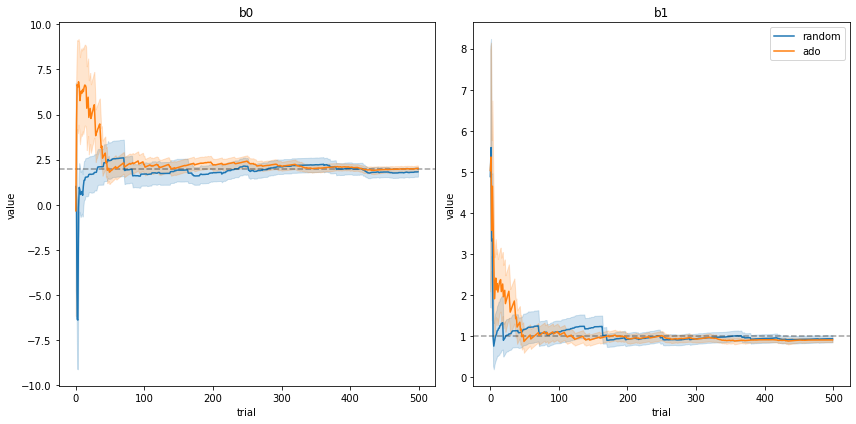

In [26]:
# Figure -----------------------------------------------

fig, axes = plt.subplots(ncols=n_param, figsize=(12, 6))

colors = [f'C{i}' for i, e in enumerate(engine)]

for i, ax in enumerate(axes):

    for j, e in enumerate(engine):

        _means = means[e][i, :]
        _stds = stds[e][i, :]

        true_p = param[i]
        ax.axhline(true_p, linestyle='--', color='black', alpha=.2)

        ax.plot(_means, color=colors[j], label=e)
        ax.fill_between(range(n_trial), _means - _stds,
                        _means + _stds, alpha=.2, color=colors[j])

        ax.set_title(f'b{i}')
        ax.set_xlabel("trial")
        ax.set_ylabel(f"value")

plt.legend()
plt.tight_layout()
plt.show()